# Color Embeddings

In [1]:
%matplotlib inline

from graph_utils import *
from color_utils import *
from PIL import Image, ImageDraw
import pickle
from pathlib import Path
import torch
import torch.autograd as autograd
from torch.autograd.variable import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import BatchNorm1d
from torch.utils.data import DataLoader, Dataset

import random
import matplotlib.pyplot as plt
import numpy as np
import math
import pickle

from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

GPU_NUM = 0
torch.cuda.set_device(GPU_NUM)
print(torch.cuda.get_device_name(GPU_NUM))

GeForce GTX 1080 Ti


# Load the survey results
Here the processed survey is loaded, name and colors tallied.

In [2]:
#import the cleaned up survey
survey_file = open("colorname_value.pl",'rb') 
survey = pickle.load(survey_file)
survey_file.close()

colors = set()
names = set()
for name, color8bit, _ in survey[:250000]:
    names.add(name)
    colors.add(color8bit)

#number of colors in the survey data
print(f"Unique colors values {len(colors)}")
#number of different color names
print(f"Unique color names {len(names)}")
print(f"Colors per name {len(colors)/len(names)}")


Unique colors values 248185
Unique color names 289
Colors per name 858.7716262975779


In [3]:
#This is the Torch dataset used to feed the model
#Each item consists of an anchor color, a positive example and a negative example
#A positive color is one that was given the same name in the survey
#A negative example is one that was given a different name

class ColorDataset(Dataset):
    def __init__(self, color_data):
        
        self.color_names = set()
        self.color_name_value = {}
        self.items = []
        
        for name, _, _ in color_data:
            self.color_names.add(name)
        
        self.color_names = list(self.color_names)
        
        for name in self.color_names:
            self.color_name_value[name] = set()
        
        for name, color8bit, _ in color_data:
            r,g,b = colorValueToRGB(color8bit, 8)
            self.color_name_value[name].add((r/255., g/255., b/255.))
            
        for color_name, color_values in self.color_name_value.items():
            for color_value in color_values:
                self.items.append((color_name, color_value))
  
    def __getitem__(self, index):
        item = self.items[index]
        color_name = item[0]
        anchor_value = item[1]
        color_values = list(self.color_name_value[color_name])
        positive_value = random.choice(color_values)
        negative_value = None
        
        while True:
            neg_name = random.choice(self.color_names)
            if color_name != neg_name:
                color_values = list(self.color_name_value[neg_name])
                negative_value = random.choice(color_values)
                break
                
        assert negative_value != None
        return (torch.tensor(anchor_value), torch.tensor(positive_value), torch.tensor(negative_value))

    def __len__(self):
        return len(self.items)

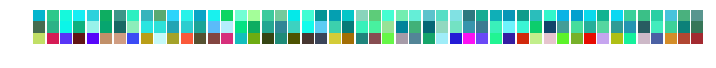

In [4]:
#Create the training and validation dataloaders

training_portion = int(len(survey)*0.9)
train_dataset = ColorDataset(survey[:training_portion])
train_dataloader = DataLoader(train_dataset,
                        shuffle=True,
                        batch_size=10000)

val_dataset = ColorDataset(survey[training_portion:10000])
val_dataloader = DataLoader(val_dataset,
                        shuffle=False,
                        batch_size=100)

#Let's visualize the training data
images = []
square_side = 50
for j in range(50):
    image = PIL.Image.new('RGB', (square_side, 3*square_side), color=0)
    draw = PIL.ImageDraw.Draw(image)
    colors = train_dataset[j]
    for i in range(3):
        color = colors[i].numpy()
        color = (int(color[0]*255),int(color[1]*255),int(color[2]*255))
        rect = [0, i*square_side, square_side, (i+1)*square_side]
        draw.rectangle(rect, fill=color)
    images.append(image)

from matplotlib.pyplot import figure, imshow, axis

fig = figure()
fig.set_size_inches((12,4))
for i in range(len(images)):
    a=fig.add_subplot(1, len(images),i+1)
    imshow(images[i])
    axis('off')

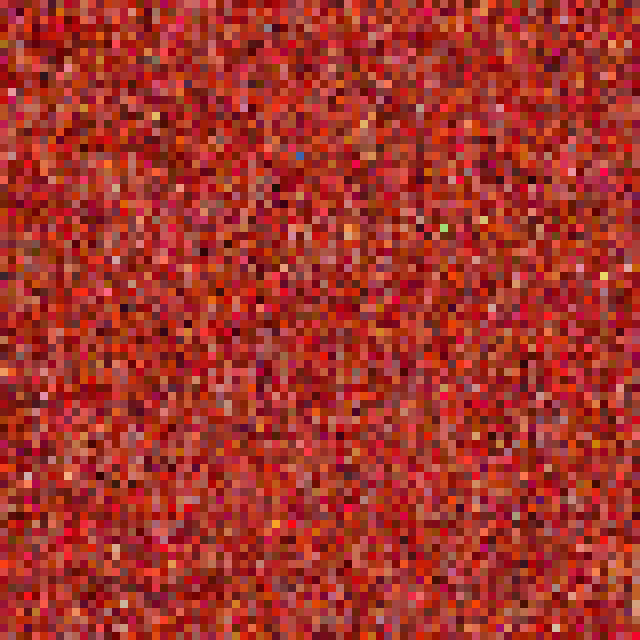

In [5]:
#Check some colors with the same names
colors = list(train_dataset.color_name_value["brick"])
side_len = int(math.sqrt(len(colors)))
square_len = 8
image_len = int(side_len*square_len)
image = PIL.Image.new('RGB', (image_len, image_len), color=0)
draw = PIL.ImageDraw.Draw(image)

for i in range(side_len):
    for j in range(side_len):
        r,g,b = colors[i*side_len+j]
        color = (int(r*255),int(g*255),int(b*255))
        rect = [i*square_len, j*square_len, i*square_len+square_len, j*square_len+square_len]
        draw.rectangle(rect, fill=color)
image

In [6]:
#check the shape of the data
viz_dataloader = DataLoader(train_dataset,
                        shuffle=True,
                        batch_size=2)
viz_batch = next(iter(viz_dataloader))
for i in range(3):
    print(viz_batch[i][0])

tensor([ 0.6039,  0.7333,  0.4510])
tensor([ 0.3569,  0.7451,  0.5608])
tensor([ 0.1608,  0.5490,  0.4196])


In [7]:
#Here's the network that will be trained
#It's a very simple fully connected network with batch normalization
class ColorModel(nn.Module):

    def __init__(self, color_dims, num_hidden):
        super(ColorModel, self).__init__()

        self.linear1 = nn.Linear(color_dims, num_hidden)
        self.linear2 = nn.Linear(num_hidden, num_hidden)
        self.linear3 = nn.Linear(num_hidden, num_hidden)
        self.linear4 = nn.Linear(num_hidden, color_dims)
        
        self.bn1 = nn.BatchNorm1d(num_hidden)
        self.bn2 = nn.BatchNorm1d(num_hidden)
        self.bn3 = nn.BatchNorm1d(num_hidden)

    def forwardOnce(self, inputs):
        out = self.bn1(F.relu(self.linear1(inputs)))
        out = self.bn2(F.relu(self.linear2(out)))
        out = self.bn3(F.relu(self.linear3(out)))
        out = F.relu(self.linear4(out))
        return out
    
    def forward(self, a, p, n):
        return (self.forwardOnce(a),
               self.forwardOnce(p),
               self.forwardOnce(n))
        
model = ColorModel(3, 50).cuda()

#Here is the triplet margin loss. It'll pull like colors together and push away negative examples
criterion = nn.TripletMarginLoss(margin=1.0).cuda()

In [8]:
#vars used in training
counter = []
training_history = []
validation_history = []
lr_history = []
cycles = 4
number_epochs = 10
itterations = 0

In [11]:
model = torch.load("model1-0.0001.pt").cuda()

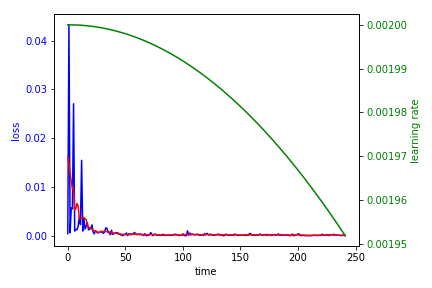

0.0004137 0.02706 0.003761 0.001346 0.001498 0.0007932 0.0006048 0.0006684 0.000388 0.0003578 0.0002428 0.0002779 0.0001974 0.0002943 5.738e-05 0.000212 4.126e-05 4.983e-05 4.931e-05 0.0001943 0.0003905 7.071e-05 0.0001983 6.165e-05 0.0001787 0.0002142 0.0003 1.525e-05 0.0001253 0.0003234 0.0001204 1.62e-05 0.0001161 9.745e-05 8.036e-05 0.0001277 0.0002496 0.0002386 9.057e-05 0.0003389 0.0003622 0.0001135 6.775e-06 7.174e-05 4.252e-05 0.0002122 0.0001325 7.435e-05 6.131e-05 

ZeroDivisionError: division by zero

In [12]:
#Start the training loop
show_plot(counter, training_history)
lr = 0.002

#using a cyclic learning rate schedule
for cycle in range(cycles):
    optimizer = optim.Adam(model.parameters(), lr = lr)
    
    #The CosineAnnealingLR scheduler will decrease the lr over time. Then we reset the lr for each cycle
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, number_epochs*len(train_dataloader))

    for epoch in range(1, number_epochs+1):
        model.train()
        for i, data in enumerate(train_dataloader, 0):
            optimizer.zero_grad()
            #anchor, positive, negative
            a, p, n = data
            a, p, n = a.cuda(), p.cuda(), n.cuda()
            a, p, n = model(a, p, n)
            loss = criterion(a,p,n)
            loss.backward()
            optimizer.step()

            counter.append(itterations)
            itterations += 1
            loss_value = loss.item()
            training_history.append(loss_value)
            lr_history.append(scheduler.get_lr()[0])

            scheduler.step()
            print(f"{loss_value:0.4}", end=" ")
            update_plot(counter, training_history, lr_history)
        
        #check the validation set
        model.eval()
        average_loss = 0
        i = 0
        for data in val_dataloader:
            a, p, n = model(a, p, n)
            loss = criterion(a,p,n)
            average_loss += loss.item()
            i += 1
            
        average_loss = average_loss/i
        print(f"Validation loss {average_loss}")

In [13]:
torch.save(model, "model1e-05.pt")

/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type ColorModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [14]:
data_len = len(train_dataset)
colors = np.zeros((data_len, 2, 3))
with torch.no_grad():
    model.eval()
    for i in range(data_len):
        if i %100000 == 0:
            print(f"{i}/{data_len}")
        color_in = train_dataset.items[i][1]
        tensor = torch.tensor(color_in).cuda()
        tensor = tensor.expand((1,3))
        color_out = model.forwardOnce(tensor)
        color_out = color_out.cpu().numpy().squeeze()    
        colors[i] = np.array([color_in, color_out])

0/2413846
100000/2413846
200000/2413846
300000/2413846
400000/2413846
500000/2413846
600000/2413846
700000/2413846
800000/2413846
900000/2413846
1000000/2413846
1100000/2413846
1200000/2413846
1300000/2413846
1400000/2413846
1500000/2413846
1600000/2413846
1700000/2413846
1800000/2413846
1900000/2413846
2000000/2413846
2100000/2413846
2200000/2413846
2300000/2413846
2400000/2413846


In [15]:
np.save("colors3.npy", colors)

In [3]:
list(colors[0][1])

[2.857027292251587, 3.9546313285827637, 2.350388765335083]

In [2]:
colors = np.load("colors3.npy")

x = []
y = []
z = []
c = []
for i in range(len(colors)):
    color_in = list(colors[i][0])
    color_out = list(colors[i][1])

    c.append(color_in)
    x.append(color_out[0])
    y.append(color_out[1])
    z.append(color_out[2])

# Visualize the original colors

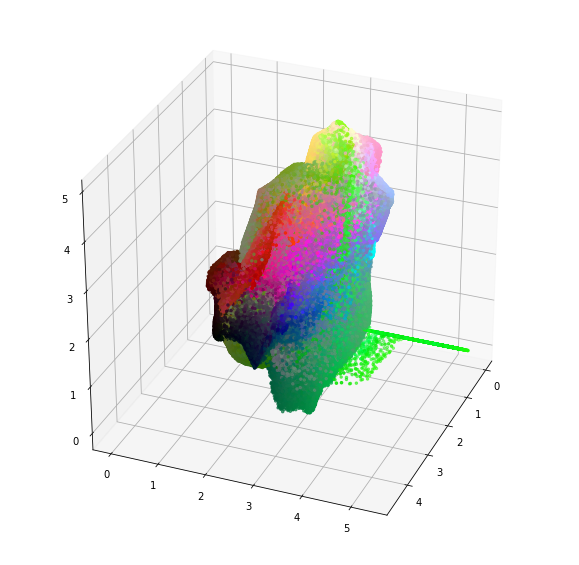

In [3]:
import ipympl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def imageFromTensor(tensor, mean, std):
    img = tensor.numpy()
    shape = tensor.shape
    img = img * std + mean
    img = img.reshape(shape[1]*shape[2])
    img = [int(x*255) for x in img]
    return PIL.Image.frombytes('L', shape[1:3], bytes(img))

def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.frombuffer ( fig.canvas.tostring_argb(), dtype=np.uint8 )
    buf.shape = ( w, h,4 )
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll ( buf, 3, axis = 2 )
    return buf

def fig2img ( fig ):
    """
    @brief Convert a Matplotlib figure to a PIL Image in RGBA format and return it
    @param fig a matplotlib figure
    @return a Python Imaging Library ( PIL ) image
    """
    # put the figure pixmap into a numpy array
    buf = fig2data ( fig )
    w, h, d = buf.shape
    buf_string = buf.tostring( )
    return PIL.Image.frombytes( "RGBA", ( w ,h ), buf_string)

def pltimg(x,y,z,c, elevation=30, azimuth=0):
    fig = Figure((10,10))
    canvas = FigureCanvas(fig)
    ax = fig.add_subplot(111, projection='3d')  
    ax.view_init(ele30vation, azimuth)
    ax.scatter(x, y, z, c=c, s=6)
    img = fig2img(fig)
    plt.close(fig)
    return img

/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/ipympl/__init__.py:19: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/brian/.conda/envs/pytorch/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/brian/.conda/envs/pytorch/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/brian/.conda/envs/pytorch/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/brian/.conda/envs/pytorch/lib/python3.6/site-pa

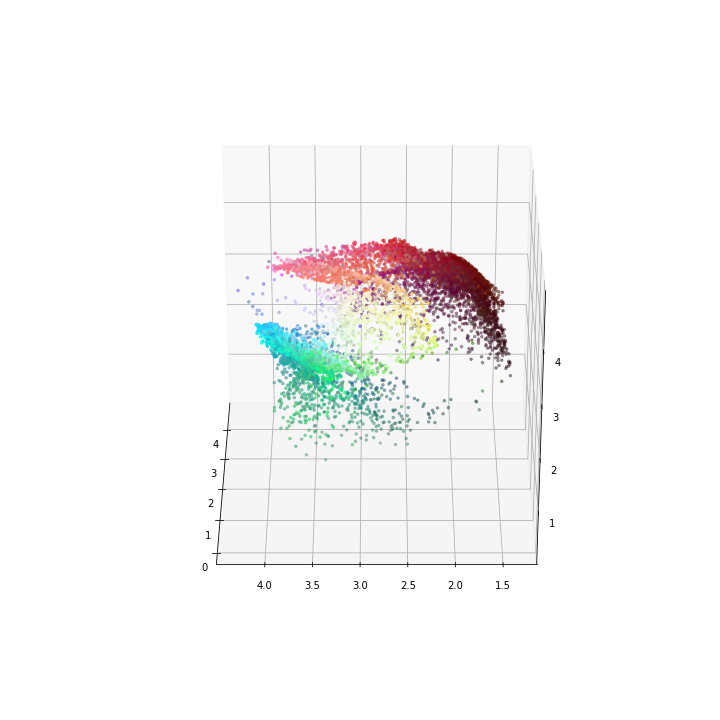

In [39]:
length = 10000
pltimg(x[:length], y[:length], z[:length], c[:length], azimuth=180)

In [4]:
import multiprocessing as mp
def spawn(func, *args):
    proc = mp.Process(target=func, args=args)
    proc.start()
    # wait until proc terminates.
    proc.join()

In [5]:
import time

def draw_fig(x,y,z,c, a):
    fig = Figure((10,10))
    canvas = FigureCanvas(fig)
    ax = fig.add_subplot(111, projection='3d')  
    ax.scatter(x, y, z, c=c, s=6)
    start = time.time()
    ax.view_init(30, a)
    img = fig2img(fig)
    img = img.convert(mode="RGB")
    file = f"./imgs/img{a:0>3d}.jpg"
    print("saving ", file, time.time() - start)
    img.save(file)
    plt.close(fig)

start = 173
end = 360

for i in range(start, end):
    print(f"spawning {i}")
    spawn(draw_fig, x, y, z, c, i)

print("Done")


spawning 173
saving  ./imgs/img173.jpg 75.57011866569519
spawning 174
saving  ./imgs/img174.jpg 75.93855333328247
spawning 175
saving  ./imgs/img175.jpg 75.7636468410492
spawning 176
saving  ./imgs/img176.jpg 76.13547992706299
spawning 177
saving  ./imgs/img177.jpg 75.9287006855011
spawning 178
saving  ./imgs/img178.jpg 75.80815649032593
spawning 179
saving  ./imgs/img179.jpg 76.16961026191711
spawning 180
saving  ./imgs/img180.jpg 75.85911345481873
spawning 181
saving  ./imgs/img181.jpg 75.87051486968994
spawning 182
saving  ./imgs/img182.jpg 76.3479311466217
spawning 183
saving  ./imgs/img183.jpg 75.67622232437134
spawning 184
saving  ./imgs/img184.jpg 76.5182945728302
spawning 185
saving  ./imgs/img185.jpg 76.16356468200684
spawning 186
saving  ./imgs/img186.jpg 75.85573387145996
spawning 187
saving  ./imgs/img187.jpg 75.84827518463135
spawning 188
saving  ./imgs/img188.jpg 75.88783097267151
spawning 189
saving  ./imgs/img189.jpg 75.747563123703
spawning 190
saving  ./imgs/img190.jp